# ***Attention U-Net architecture*** *for multi-class semantic segmentation*

<p align="center">
  <img src="Images/AttUNEt.png" alt="AttUNet" title = "AttUNet" width="600"/> <br>
  <em> Attention U-Net Architecture </em>
</p>

<p align="center">
  <img src="Images/AttentionUNet (2).png" alt="Attention Gate" title = "Attention Gate" width="600"/> <br>
  <em> Slightly modified Attention Gate </em>
</p>

## *Main idea of the additive Attention gate:*
- Motivation: Skip connections in the original U-Net architecture are abstracted in the shallower layers of the encoder. In spite of preserving the spatial information, it does not contain rich feature information because it is in the upper layers of the U-Net. Therefore, the idea of extracting both the deeper maps as well as the shallower maps to preserve the feature and spatial information respectively, seems prominent. And we have the attention gate.
- x: skip-connection feature map in the original U-Net architecture
- g: the gating feature map (gating signal) - the feature maps in the prior layer before upsampling
<br>**Flow**:
- g is passed into the convolution layer of kernel size: 1x1, stride: 1 and output channels: 128 => [64,64,128]
- x is passed into the convolution layer of kernel size: 1x1, stride: 2 and output channels: 128 => [64,64,128]
- The resulting feature maps are added together element-wise => [64,64,128]
- Passed into ReLU() => [64,64,128]
- Attention scoring layer is attained by applying 1x1x1 convolution with stride of 1 => [64,64,1]
- The resulting feature map is compressed using a sigmoid function to range [0,1] => [64,64,1]
- Upsampled to [128,128,1]
- The final featrure map is multiplied with the skip connection map x, element-wise => [128,128,1]


**Adjustment made to the original notion of Attention Gate**:
- g: 1x1 convolution, stride = 1, output channels = skip channels
- x: 1x1 convolution, stride = 1, output channels = same => Preserving the spatial dimension of skip feature map
- g: inerpolated to match the dimension of x
- Then, we repeat the same process, by the end, no more upsampling is needed.

### Importing libraries and modules

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import v2
import cv2
import random
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms.functional as TF
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

## **Attention gate design**

In [ ]:
class AttentionGate (nn.Module):
    def __init__ (self, gate_channels, skip_channels):
        super(AttentionGate,self).__init__()
        self.gate_conv = nn.Conv2d(in_channels=gate_channels, out_channels=skip_channels, kernel_size=1, stride = 1)
        self.skip_conv = nn.Conv2d(in_channels=skip_channels, out_channels=skip_channels, kernel_size=1, stride=1)
        self.relu = nn.ReLU()
        self.aconv = nn.Conv2d(in_channels=skip_channels, out_channels=1, kernel_size=1, stride = 1)
        self.sigmoid = nn.Sigmoid()
        self.norm = nn.BatchNorm2d(skip_channels)
        
    def forward(self, gate, skip):
        gate = self.norm(self.gate_conv(gate))
        skip = self.norm(self.skip_conv(skip))
        gate = F.interpolate(gate ,size = skip.shape[2:], mode='bilinear', align_corners=True) 
        x = gate + skip
        x = self.relu(x)
        x = self.aconv(x)
        x = self.sigmoid(x)
        return x*skip

## **Encoder**

In [ ]:
class EncodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding = 1):
        super(EncodeBlock, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = 1, padding = padding), #For changes in spatial size (Downsample)
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding = padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.down_sample = nn.MaxPool2d(kernel_size=2, stride = 2)

    def forward(self, x):
        x = self.model(x)
        skip_map = x.clone() # Skip connections
        x = self.down_sample(x)
        return x, skip_map

## **Decoder**

In [ ]:
class DecodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels, padding = 1):
        super(DecodeBlock, self).__init__()
        # Upsampling (in_channels, out_channels)
        self.up_sample = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride = 2, padding = 0)
        # Concatenation of skipped feature map and upsampled feature map
        # Convolutions (out_channels + skip_channels, out_channels) => Ouput: out_channels, output spatial size = x2 input size
        self.model = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, stride = 1, padding = padding), #For changes in spatial size (Downsample)
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding = padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.25)
        )
        self.relu = nn.ReLU()
        
    def forward(self, x, attention_sig):
        x = self.up_sample(x)
        #x = torch.nn.functional.interpolate(x, size=skip_map.shape[2:], mode='bilinear', align_corners=False)
        # print(x.shape, skip_map.shape)
        x = torch.concat([x,attention_sig], dim = 1)
        x = self.model(x)
        return x

## **Bottleneck**

In [ ]:
class BottleNeck(nn.Module):
    def __init__ (self, in_channels, mid_channels, padding = 1):
        super(BottleNeck, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding = padding, stride = 1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding = padding, stride = 1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.25)
        )
    def forward(self, x):
        x = self.conv(x)
        return x

## **Att U-Net**

In [ ]:
class UNet(nn.Module):
    def __init__ (self, AttentionGate, EncodeBlock,BottleNeck, DecodeBlock, 
                  num_classes, in_channels = 3, planes = [64,128,256,512,1024]):
        super(UNet, self).__init__()

        length = len(planes)
        #--- Encoding ---
        self.encode_layer1 = EncodeBlock(in_channels, planes[0])

        self.encode_layers = nn.ModuleList()
        for idx in range (1, length-1):
            en_layer = EncodeBlock(planes[idx-1],planes[idx])
            self.encode_layers.append(en_layer)
        
        #(Connection between Contracting and Expansive paths), in_channels = 512, mid_channels = 1024
        #--- Bottleneck --- 
        self.bottleneck = BottleNeck(planes[-2], planes[-1])

        #--- Decoding ---
        self.attention_gate1 = AttentionGate(planes[-1],planes[-2])
        self.decode_layer1 = DecodeBlock(planes[-1], planes[-2], planes[-2])

        self.attention_gates =nn.ModuleList()
        self.decode_layers = nn.ModuleList()
        for idx in range (1, length-1):
            attention_gate = AttentionGate(planes[-1-idx],planes[-2-idx])
            dec_layer = DecodeBlock(planes[-1-idx], planes[-2-idx], planes[-2-idx])
            self.attention_gates.append(attention_gate)
            self.decode_layers.append(dec_layer)

        self.final_conv = nn.Conv2d(in_channels=planes[0], out_channels=num_classes, kernel_size=1, stride = 1)

    def forward(self, x):
        skips = []
        
        #Encoding
        x, skip_map1 = self.encode_layer1(x)
        skips.append(skip_map1)
        for en_layer in self.encode_layers:
            x, skip_map = en_layer(x)
            skips.append(skip_map)

        #BottleNeck
        x = self.bottleneck(x)

        #Decoding
        gate1 = self.attention_gate1(x,skips[-1])
        x = self.decode_layer1(x, gate1)
        
        for idx, (dec_layer, attention_gate) in enumerate (zip(self.decode_layers, self.attention_gates)):
            gate = attention_gate(x,skips[-2-idx])
            x = dec_layer(x, gate)
        
        #Final convolution
        logits = self.final_conv(x)

        return logits

In [ ]:
def UNet12 (num_classes = 12, in_channels = 3):
        planes =  [64,128,256,512, 1024]
        return UNet(AttentionGate, EncodeBlock, BottleNeck, DecodeBlock, num_classes, in_channels, planes = planes)

### **Dice score (Dice loss) - Dice Similarity Coefficient**

<p align="center">
  <img src="Images/Dice.png" alt="Dice score" width="600"/> <br>
  <em> Dice Score Coefficient </em>
</p>

- Dice coefficient is used to measure the overlap between predicted and ground truth. Dice focuses on the correctness of the predicted shapes and works well even when classes are imbalanced.
- Dice coefficients is calculated:
$$
\text{Dice score}(A,B) = \frac{2\times{|A\cap B|}}{|A| + |B|}
$$
- Dice loss is defined as:
$$
\newline
\text{Dice loss} = 1 - \text{Dice score}
$$
- Intuitively, it makes sense how this works, when A and B are overlapping completely, the result of $|A\cap B|=1$ thus the dice coefficient will be exactly 1 => Dice loss = 0.
- Therefore, it is obvious that we would want to minimize the dice loss.
- **Hard Dice Score** = overlap between binary masks after thresholding or argmax (For accuracy evaluation)
- **Soft Dice Score** = overlap between continuous probability maps and one-hot labels (For training)

### **Soft dice loss**

In [ ]:

'''---Soft Dice Loss---'''
class DiceLoss (nn.Module):
    def __init__(self, epsilon = 1e-8):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon
    
    def forward (self, pred, mask): 
        #Both pred and mask are converted into tensors before passing in
        #Mask's input shape: [B,H,W]
        #Logits(Predicted image)'s shape: [B,C,H,W]

        pred_softmax = F.softmax(pred, dim = 1) #Softmax is computed along the dimension 1 which is a spatial location of the pixel that spans the entire number of channels => We get the probability vector per pixel.
        
        B,C,H,W = pred.shape
        #One-hot encode the mask
        mask_onehot = F.one_hot(mask, num_classes=C).float() #[B,H,W] -> [B,H,W,C], thats how F.one_hot works, e.g., [N,] -> [N,C]
        mask_onehot = mask_onehot.permute(0,3,1,2) #[B,C,H,W]
        
        # dims = (0,2,3), with sum(dim = dims) it returns a tensor that is dim 1 1D tensor
        dims = (0,2,3)
        intersection = (pred_softmax*mask_onehot).sum(dim = dims) #[C,]
        pred_sum = pred_softmax.sum(dim=dims) #[C,]
        mask_sum = mask_onehot.sum(dim=dims) #[C,]

        dice_score = (2*(intersection)+self.epsilon)/(pred_sum+mask_sum+self.epsilon) #[C,]
        loss = 1 - dice_score.mean() # float
        return loss

'''---Hard Dice Score(Not differentiable)---'''
def dice_score(pred,mask, num_classes = 12, epsilon = 1e-8, verbose = False):
    # pred is already been convereted to [B,H,W] using `preds = pred.argmax(dim=1)` which would return a feature map with the predcited class per pixel
    if pred.shape != mask.shape:
        pred = pred.argmax(dim=1)

    dice_scores,dice_per_class = [],[]
    for cls in range(num_classes):
        pred_class = (pred==cls).float()
        mask_class = (mask==cls).float()
        intersection = (pred_class*mask_class).sum()
        total = pred_class.sum()+mask_class.sum()
        if total == 0: 
            continue #Skip the classes where there are none present
        
        dice = (2*intersection)/(total + epsilon)
        score = dice.item()
        dice_scores.append(dice.item())
        dice_per_class.append((cls,dice))

        if verbose == True:
            print(f'Class{cls}: Dice score = {score:.4f}')
        
    mean_dice = sum(dice_scores)/len(dice_scores) if dice_scores else 0.0
    return mean_dice, dice_per_class
        

- Put the softmaxed predicted segmented image as $\mathbf{X}$ and the ground truth mask as $\mathbf{Y}$.
- $\newline \mathbf{x}_{i,j}^{k}$ is an 1D tensor of size [C,] same goes for $\mathbf{y}_{i,j}^{k}$. It implies that at location $i^{th},j^{th}$ at batch $k^{th}$, it holds the probability vector spans across all channels.
- $\mathbf{x}, \mathbf{y}$ denote the tensors of the predicted images and masks of the size $[B,C,H,W]$
- $\mathbf{X}, \mathbf{Y}$ denote the sum of the tensors along the channel dimension, size $[C,]$
- The soft dice loss can be defined as follow:
$$
\mathbf{X} \cap \mathbf{Y} = \sum_{k=1}^{B} \sum_{j=1}^{H} \sum_{i=1}^{W} \mathbf{x}_{i,j}^{k} \odot \mathbf{y}_{i,j}^{k}
$$
$$
\mathbf{X} =  \sum_{k=1}^{B} \sum_{j=1}^{H} \sum_{i=1}^{W} \mathbf{x}_{i,j}^{k}
$$
$$
\mathbf{Y} =  \sum_{k=1}^{B} \sum_{j=1}^{H} \sum_{i=1}^{W} \mathbf{y}_{i,j}^{k}
$$
$$
\text{Dice score}(\mathbf{x,y}) = \frac{2|\mathbf{X} \cap \mathbf{Y}|}{|\mathbf{X}|+|\mathbf{Y}| + \epsilon} = \frac{2 (\sum_{k=1}^{B} \sum_{j=1}^{H} \sum_{i=1}^{W} \mathbf{x}_{i,j}^{k} \odot \mathbf{y}_{i,j}^{k})}{\sum_{k=1}^{B} \sum_{j=1}^{H} \sum_{i=1}^{W} \mathbf{x}_{i,j}^{k}+\sum_{k=1}^{B} \sum_{j=1}^{H} \sum_{i=1}^{W} \mathbf{y}_{i,j}^{k}+\epsilon}
$$
$$
\text{Dice loss}(\mathbf{x,y}) = 1 - \text{Dice score}(\mathbf{x,y})
$$
- The point of adding an additional $\epsilon$ in the numerator is to avoid the specific case when there are no presence of a class in a mask or prediction, thus this would result in dice_score = 0 if no epsilon is padded into the numerator, when dice = 0 then dice loss = 1 which is large and the model is being penalized even though it guessed correctly. => Model is only penalized when it predicts wrongly.
- Thus when that case happens, then $\text{Dice score} = \frac{\epsilon}{\epsilon} = 1$, and so $\text{Dice loss} = 0$. => Model guesses right when there are no presence of such classes => No need to learn.
- Or another solution is to skip those classes and evaluate only those that are active.

### **Tversky loss**:
- The loss function is proposed based of Tversky similarity index (a paper in 1977) and is a more generalized loss fucntion than Dice loss.
- The motivation behind Tversky loss is due to the imbalance in dataset that certain minority classes would have poor performance while the majority classes will be overly emphasized by the model in order to minize loss.
- Tversky loss introduces adjustable weights for false positives $(\text{FP})$ and false negatives $(\text{FN})$, allowing it to adapt to class imbalance or taks-specific priorities.
- It's important to note that the Tverksy index is calculated with respect to each individual class (channel) which we have one-hot encoded then take the average to compute the loss. => This would make more sense on how specifying the weights of FP and FN matters.
- The Tversky index is given as, of class $\text{c}$ :
$$
\text{Tversky}_c = \frac{\text{TP}_c}{\text{TP}_c+\alpha \cdot \text{FP}_c + \beta \cdot \text{FN}_c}
$$
- Dice coefficient is when $\alpha=0.5$ and $\beta=0.5$:
$$
\text{Dice}_c = \frac{2\text{TP}_c}{2\text{TP}_c+  \text{FP}_c + \text{FN}_c} 
$$
- Tversky loss is defined as:
$$
\text{Tversky loss} = \frac{1}{\text{C}}\sum_{c=1}^{C}(1-\text{Tversky}_c)
$$



In [ ]:
'''---Tversky Loss---'''
class TverskyLoss (nn.Module):
    def __init__(self,alpha = 0.5, beta = 0.5, epsilon = 1e-8, weight = None):
        super(TverskyLoss, self).__init__()
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        self.weight = weight
    
    def forward (self, pred, mask): 
        #Both pred and mask are converted into tensors before passing in
        #Mask's input shape: [B,H,W]
        #Logits(Predicted image)'s shape: [B,C,H,W]

        pred_softmax = F.softmax(pred, dim = 1)# Softmax is computed along channel dimension (dim=1), which gives a class probability vector per pixel.
        
        B,C,H,W = pred.shape
        #One-hot encode the mask
        mask_onehot = F.one_hot(mask, num_classes=C).float() #[B,H,W] -> [B,H,W,C], thats how F.one_hot works, e.g., [N,] -> [N,C]
        mask_onehot = mask_onehot.permute(0,3,1,2) #[B,C,H,W]
        
        # dims = (0,2,3), with sum(dim = dims) it returns a tensor that is dim 1 1D tensor
        dims = (0,2,3)
        tp = (pred_softmax*mask_onehot).sum(dim = dims) #[C,]
        fp = pred_softmax.sum(dim=dims) - tp
        fn = mask_onehot.sum(dim=dims) - tp

        tversky_index = (tp+self.epsilon)/(tp+self.alpha*fp+self.beta*fn+self.epsilon) #[C,]

        if self.weight is not None:
            self.weight = self.weight.to(pred.device) #Added to gpu
            loss = (1-tversky_index)*self.weight
            return loss.mean()
        else:
            loss = 1 - tversky_index.mean() # float
            return loss

### **TP, FP, FN, TN:**
- Suppose that the mask is $\mathbf{M}$ and the predicted segment image is $\mathbf{N}$
- **True positive**: Pred says 'yes' and it's correct (1|1)
$$
|\mathbf{M} \cap \mathbf{N}| = \sum_{c=1}^{C}\text{TP}_c 
$$
- **False positive**: Pred says 'yes' but it's false (1|0)
$$
|\mathbf{N}| = \sum_{c=1}^{C}(\text{TP}_c + \text{FP}_c)
$$
- **False negative**: Pred says 'no' but it's false (0|1)
$$
|\mathbf{M}| = \sum_{c=1}^{C}(\text{TP}_c + \text{FN}_c)
$$
- **True negative**: Pred says 'no' and it's correct => This case is ignored because it does not help much with learning. (0|0)
$$
$$
- **Precision**: how many of the predicted positive pixels are truly positive.
$$
\text{Precision}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FP}_c}
$$
- **Sensitivity(Recall)**: how many of the predicted pixels are correct.
$$
\text{Sensitivity}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}
$$

In [ ]:
import csv

'''Computing batch's precision and sensitivity'''
def precision_sensitivity(pred,mask, num_classes = 12, verbose = False, save_csv = False):
    # pred is already been convereted to [B,H,W] using `preds = pred.argmax(dim=1)` which would return a feature map with the predcited class per pixel
    if pred.shape != mask.shape:
        pred = pred.argmax(dim=1)

    precision_per_class,sensitivity_per_class = [],[]

    if verbose == True: print('\n')
    for cls in range(num_classes):
        pred_class = (pred==cls).float()
        mask_class = (mask==cls).float()

        tp = (pred_class*mask_class).sum()
        fp = ((pred_class==1)&(mask_class==0)).sum() #pred says 'yes'-1 but it's 'no'-0 (This code finds those pixels)
        fn = ((pred_class==0)&(mask_class==1)).sum() #pred says 'no'-0 but it's 'yes'-1

        precision = tp/(tp+fp+1e-8)
        sensitivity = tp/(tp+fn+1e-8)

        precision_per_class.append(precision)
        sensitivity_per_class.append(sensitivity)

        if verbose == True:
            print(f'Class{cls}: Precision = {precision*100:.2f}%, Sensitivity = {sensitivity*100:.2f}%')
        
    if save_csv == True:
        csv_path = './precision_sensitivity.csv'
        header = ['Class', 'Precision', 'Sensitivity']
        rows = [(cls, f'{precision_per_class[cls]:.4f}', f'{sensitivity_per_class[cls]:.4f}') for cls in range(num_classes)]
        os.makedirs(os.path.dirname(csv_path), exist_ok=True)
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)
            writer.writerows(rows)

    return sum(precision_per_class)/num_classes, sum(sensitivity_per_class)/num_classes

### **Focal loss**
- Focal loss is defined as:
$$
\text{FL}(p_t) = -(1-p_t)^{\gamma}\cdot log(p_t)
$$
- With $p_t$: shorthand for the probability assigned to the true class (the '1' in the one-hot truth vector). 
- $\gamma \in [0,5]$, when $\gamma = 0$ then Focal Loss = Cross Entropy Loss.
- Cross entropy only pays attention to the probability of the correct class, to redistribute probabilities and make the true class more probable.
- For a batch of N samples (pixels):
$$
\text{FL} = \frac{1}{N} \sum_{i=1}^{N}-(1-p^{(i)}_t)^{\gamma}\cdot log(p^{(i)}_t)
$$
- Cross entropy loss for 1 sample:
$$
\text{CE} = -log(p_t)
\newline
$$
=> `torch.exp(-ce_loss)` = $e^{log(p_t)}$ = $p_t$

In [ ]:
'''---Focal Loss---'''
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # Can be a list/tuple or scalar
        self.reduction = reduction

    def forward(self, logits, mask):
        # logits: [B, C, H, W], mask: [B, H, W]
        ce_loss = F.cross_entropy(logits, mask, reduction='none')  # [B, H, W]
        pt = torch.exp(-ce_loss)  # pt = softmax prob of true class

        focal_factor = (1 - pt) ** self.gamma

        if self.alpha is not None:
            if isinstance(self.alpha, (list, tuple, torch.Tensor)):
                alpha = self.alpha.to(device)
                at = alpha[mask]  # shape: [B, H, W]
            else:
                at = self.alpha
            focal_factor *= at

        loss = focal_factor * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss  # no reduction


## *Train batch and get model*

Try loss function of all three: Dice + CE + Focal

In [ ]:
def get_model(UNet = UNet12, tversky_loss = TverskyLoss, device = 'cuda', lr = 1e-3
              , weight_decay = 1e-5, optim = 'Adam', class_freq = None):
    
    #---Model---
    model = UNet().to(device)
    
    #---Loss functions---
    class_freq = class_freq.to(device)
    weights = 1.0/(class_freq+1e-6) #Based off the class frequency, the weights will be higher to rare classes and lower to common classes
    weights = weights/weights.sum()*len(class_freq) #Normalize
    
    focal_loss = FocalLoss(gamma = 2, alpha = weights) 
    ce_loss = nn.CrossEntropyLoss(weight=weights) 
    dice_loss = tversky_loss(alpha = 0.5, beta = 0.5, weight=weights)
    
    
    #---Optimizers---
    if optim == 'Adam':
        optimizer = Adam(model.parameters(), lr = lr, weight_decay = weight_decay) 
    elif optim == 'SGD':
        optimizer = SGD(model.parameters(), momentum=0.9, nesterov=True,lr = lr, weight_decay = weight_decay) 
    else: 
        raise ValueError('Unsupported Optimizer')
    
    return model, dice_loss, ce_loss,focal_loss, optimizer

In [ ]:
def train_batch(model, data_batch, optimizer, dice_loss, ce_loss,focal_loss, device = 'cuda'):
    model.train()
    img, mask = data_batch
    img = img.to(device)
    mask = mask.to(device).squeeze(1)
    
    logits = model(img)
    _, _, h, w = logits.shape
    mask = mask[:, :h, :w]
    
    optimizer.zero_grad()
    
    batch_loss = 0.6*dice_loss(logits, mask) + 0.0*ce_loss(logits,mask) + 0.4*focal_loss(logits,mask)
    batch_loss.backward()
    optimizer.step()

    # ---Accuracy evaluation---
    preds = logits.argmax(dim = 1) #This will return [B,H,W] as it scans through dimension 1 (:C) to find the max value index
    dice_acc, _ = dice_score(pred = preds, mask= mask)
    pixel_acc = (preds==mask).float().mean() #Mask is also [B,H,W]
    return batch_loss.item(), dice_acc, pixel_acc.item()

## *Loading dataset*

### Augmentation

In [ ]:
class AugTransform:
    def __init__(self, resize = (312,312), cropsize = (256,256)):
        self.resize = v2.Resize(resize)
        self.cropsize = cropsize
    def __call__(self, image, mask):
        #Convert ndarray to tensor
        image = torch.from_numpy(image).permute(2,0,1).float()/255.0
        mask = torch.from_numpy(mask).long().unsqueeze(0)
        
        #Resizing
        image = self.resize(image)
        mask = self.resize(mask)

        #Random crop
        i,j,h,w = v2.RandomCrop.get_params(image, output_size=self.cropsize)
        image = TF.crop(image, i,j,h,w)
        mask = TF.crop(mask, i,j,h,w)
        
        #Random horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        #Random vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        #Color jitter
        # color_jitter = v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        # image = color_jitter(image)
        
        #Random rotation
        # if random.random() > 0.5:
        #     image = TF.rotate(image, angle=random.uniform(-15, 15))
        #     mask = TF.rotate(mask, angle=random.uniform(-15, 15))
        
        # Normalized the image
        image = v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])(image)
        
        return image, mask

### *Custom dataset*

In [ ]:
class SegData(torch.utils.data.Dataset):
    def __init__(self, split, root = './data_temp/dataset1', size = (256,256), joint_transform = None):
        self.image_dir = os.path.join(root, f'images_prepped_{split}')
        self.mask_dir = os.path.join(root,f'annotations_prepped_{split}')
        self.size = size
        self.joint_transform = joint_transform

        # Get the roots of the image files
        self.items = [
            os.path.splitext(f)[0]
            for f in os.listdir(self.image_dir)
            if f.endswith('.png')
        ]

    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        # --- Specify file paths ---
        item = self.items[idx]
        image_path = os.path.join(self.image_dir, f'{item}.png')
        mask_path = os.path.join(self.mask_dir, f'{item}.png')

        # --- Read Images and Masks ---
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
        mask = cv2.imread(mask_path, 0) # flag = cv2.IMREAD_GRAYSCALE

        # --- Transformation ---
        if self.joint_transform is not None:
            image, mask = self.joint_transform(image, mask)
        else:
            image = cv2.resize(image, self.size) # Resize image
            image = torch.from_numpy(image).permute(2,0,1).float()/255 # Range [0,1]

            mask = cv2.resize(mask, self.size)
            mask = torch.from_numpy(mask).long().unsqueeze(0) #[1,H,W]
            
        return image, mask

## ***Training***

In [ ]:
train_data1 = SegData(split='train', joint_transform=AugTransform())
train_data2 = SegData(split='train', joint_transform=AugTransform())
train_data = torch.utils.data.ConcatDataset([train_data1,train_data2])
eval_data = SegData(split='test')

trn_dl = DataLoader(train_data, batch_size = 4, shuffle = True)
eval_dl = DataLoader(eval_data, batch_size = 1, shuffle=True)

### Count the number of pixels and frequency of each class in the train dataset masks

- This is to find the weights for each class, which combats the class imbalance in Cityscape-like dataset

In [ ]:
def class_counter(dataset, num_classes = 12):
    class_count = torch.zeros(num_classes)
    
    for i in range (len(dataset)):
        _, mask = dataset[i]
        for cls in range(num_classes):
            class_count[cls] += (mask==cls).sum()
    total_pixels = class_count.sum()
    class_freq = class_count/total_pixels

    return class_count, class_freq

class_counts, class_freq = class_counter(dataset=train_data)
for idx in range(len(class_counts)):
    print(f'Class {idx}: counts = {int(class_counts[idx])}, frequency = {class_freq[idx]*100:.2f}%')

Class 0: counts = 7001564, frequency = 14.56%
Class 1: counts = 11171547, frequency = 23.22%
Class 2: counts = 725570, frequency = 1.51%
Class 3: counts = 15282355, frequency = 31.77%
Class 4: counts = 2390182, frequency = 4.97%
Class 5: counts = 4674174, frequency = 9.72%
Class 6: counts = 749518, frequency = 1.56%
Class 7: counts = 721174, frequency = 1.50%
Class 8: counts = 3227540, frequency = 6.71%
Class 9: counts = 413246, frequency = 0.86%
Class 10: counts = 281143, frequency = 0.58%
Class 11: counts = 1465411, frequency = 3.05%


torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
Learning rate: 0.000108
Current epoch: 0, loss: 0.7240, pixel accuracy = 46.7001%, dice score = 26.3493%
Learning rate: 0.000116
Current epoch: 1, loss: 0.6826, pixel accuracy = 57.2339%, dice score = 34.8208%
Learning rate: 0.000124
Current epoch: 2, loss: 0.6598, pixel accuracy = 61.9285%, dice score = 38.7369%
Learning rate: 0.000132
Current epoch: 3, loss: 0.6400, pixel accuracy = 65.7578%, dice score = 42.2450%
Learning rate: 0.000140
Current epoch: 4, loss: 0.6313, pixel accuracy = 66.7385%, dice score = 43.1719%
Learning rate: 0.000148
Current epoch: 5, loss: 0.6175, pixel accuracy = 68.5618%, dice score = 45.1531%
Learning rate: 0.000156
Current epoch: 6, loss: 0.6094, pixel accuracy = 69.7530%, dice score = 46.1296%
Learning rate: 0.000164
Current epoch: 7, loss: 0.6013, pixel accuracy = 70.5415%, dice score = 47.0416%
Learning rate: 0.000172
Current epoch: 8, loss: 0.5931, pixel accuracy = 71.2834%, dice score = 47.965

c:\Users\minhc\torch311\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Learning rate: 0.000500
Current epoch: 49, loss: 0.4485, pixel accuracy = 83.3285%, dice score = 63.5462%
Learning rate: 0.000485
Current epoch: 50, loss: 0.4556, pixel accuracy = 83.1054%, dice score = 63.0785%
Learning rate: 0.000470
Current epoch: 51, loss: 0.4526, pixel accuracy = 83.4664%, dice score = 63.2827%
Learning rate: 0.000456
Current epoch: 52, loss: 0.4315, pixel accuracy = 84.9130%, dice score = 65.3173%
Learning rate: 0.000443
Current epoch: 53, loss: 0.4319, pixel accuracy = 84.6305%, dice score = 65.2900%
Learning rate: 0.000429
Current epoch: 54, loss: 0.4299, pixel accuracy = 84.8689%, dice score = 65.5403%
Learning rate: 0.000416
Current epoch: 55, loss: 0.4198, pixel accuracy = 85.5097%, dice score = 66.4798%
Learning rate: 0.000404
Current epoch: 56, loss: 0.4251, pixel accuracy = 85.2317%, dice score = 65.9271%
Learning rate: 0.000392
Current epoch: 57, loss: 0.4221, pixel accuracy = 85.6000%, dice score = 66.2740%
Learning rate: 0.000380
Current epoch: 58, los

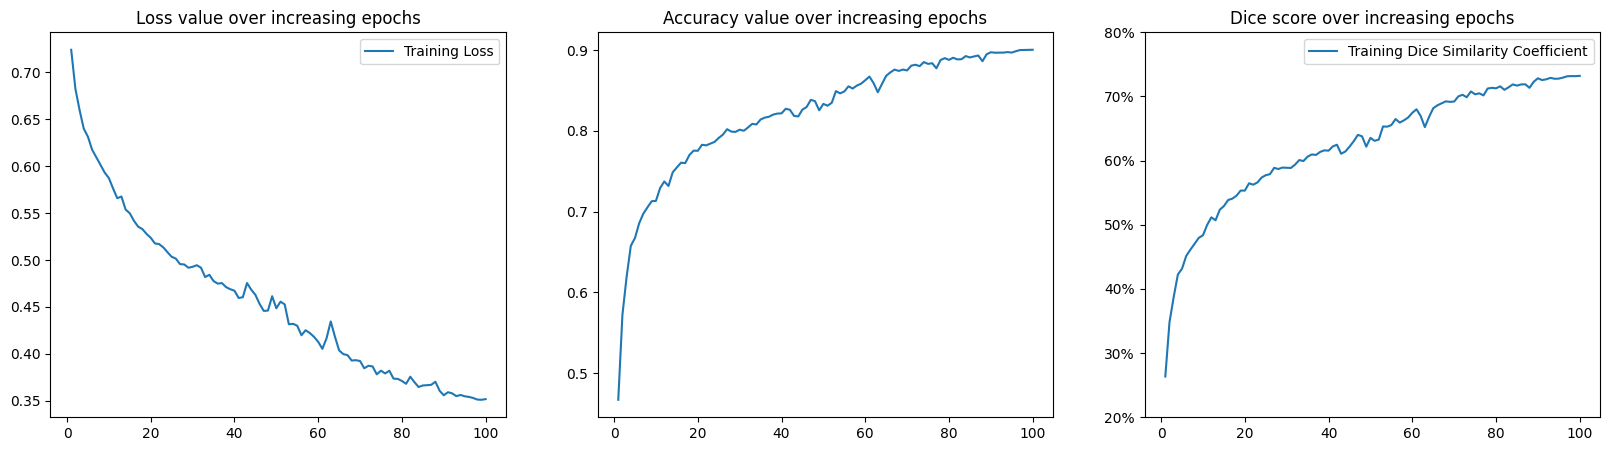

In [ ]:
model, dice_loss, ce_loss, focal_loss, optimizer = get_model(UNet=UNet12, class_freq=class_freq)
train_losses, train_accuracies, train_dice_score = [],[],[]

epochs = 100

base_lr = optimizer.param_groups[0]['lr']  # e.g., 0.001
start_lr = base_lr * 0.1
end_lr = base_lr * 0.5

scheduler1 = lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=0.5, total_iters=50)

# Create ExponentialLR with correct base_lrs = [end_lr]
scheduler2 = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
scheduler2.base_lrs = [end_lr for _ in optimizer.param_groups]

scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[50])


model.train()

img, mask =next(iter(trn_dl))
print(img.shape, mask.shape)  # Should print torch.Size([B, 3, 224, 224]), torch.Size([B, 1, 224, 224])

for epoch in range(epochs):
    epoch_losses, epoch_accuracies, epoch_dice_score = [],[],[]

    for idx, batch in enumerate(trn_dl):
        batch_loss,dice_acc,batch_pixel_acc = train_batch(model, batch, optimizer, dice_loss=dice_loss, ce_loss=ce_loss,focal_loss=focal_loss)
        epoch_losses.append(batch_loss)
        epoch_accuracies.append(batch_pixel_acc)
        epoch_dice_score.append(dice_acc)


    epoch_loss = np.array(epoch_losses).mean()
    epoch_acc = np.array(epoch_accuracies).mean()
    epoch_dice = np.array(epoch_dice_score).mean() 

    scheduler.step()

    print(f"Learning rate: {scheduler.get_last_lr()[0]:.6f}")

    print(f'Current epoch: {epoch}, loss: {epoch_loss:.4f}, pixel accuracy = {(epoch_acc*100):.4f}%, dice score = {(epoch_dice*100):.4f}%')
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    train_dice_score.append(epoch_dice)

'''---Plotting and Visualizing convergence---'''
it=np.arange(epochs)+1
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('Loss value over increasing epochs')
plt.plot(it, train_losses, label='Training Loss')
plt.legend()
plt.subplot(132) 
plt.title('Accuracy value over increasing epochs')
plt.plot(it, train_accuracies, label='Training Accuracy')
plt.subplot(133) 
plt.title('Dice score over increasing epochs')
plt.plot(it, train_dice_score, label='Training Dice Similarity Coefficient')

ax = plt.gca()
ticks = ax.get_yticks()
ax.set_yticks(ticks)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()  

### Visualisation of segmented output

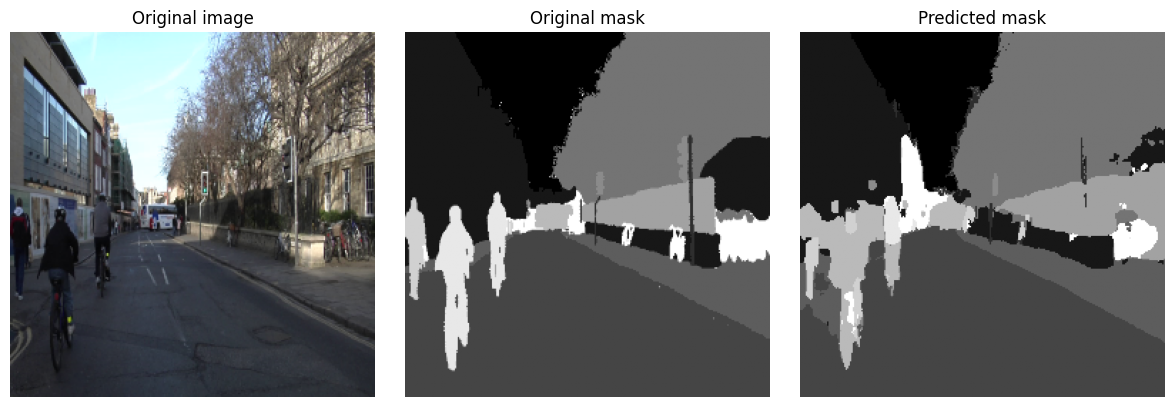

In [ ]:
import matplotlib.pyplot as plt

train_dataset = DataLoader(SegData(split='train'), batch_size=1,shuffle=True)
img, mask = next(iter(eval_dl))     # [B, 3, H, W], [B, 1, H, W]
img = img.to(device)
mask = mask.to(device)

with torch.no_grad():
    output = model(img)
    output = torch.argmax(output, dim=1)  # [B, H, W]

# Convert tensors to CPU for visualization
img_vis = img[0].permute(1, 2, 0).cpu().numpy()        # [H, W, 3]
mask_vis = mask[0].squeeze().cpu().numpy()             # [H, W]
pred_vis = output[0].cpu().numpy()                     # [H, W]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_vis)
axs[0].set_title("Original image")

axs[1].imshow(mask_vis, cmap='gray')
axs[1].set_title("Original mask")

axs[2].imshow(pred_vis, cmap='gray')
axs[2].set_title("Predicted mask")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
